In [2]:
# Install required libraries
!pip install Sastrawi bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 61.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━

In [3]:
# Mounting directory into google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change directory
%cd /content/drive/MyDrive/dataset-indonesian-ai

/content/drive/MyDrive/dataset-indonesian-ai


In [5]:
# Load libraries
import os
import pandas as pd
from random import choice
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [6]:
# Set styling
plt.style.use("ggplot")

In [78]:
# Load dataset
data = pd.read_csv("tweet.csv", usecols = ['sentimen', 'tweet'])

In [79]:
# Overview information dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 28.5+ KB


In [80]:
# Overview example data
data.sample(5)

,sentimen,tweet
77,netral,Katanya Jas itu harga mahal dan pakaian orang2...
1749,netral,Mau gaji dokter hewan minimal 10 juta? Tusuk P...
515,netral,TIDAK impor hal yang MUDAH. Imbasnya harga SEM...
712,positif,"When prabowo said : ""ekonomi kita sedang salah..."
1382,positif,Jokowi Optimis Indonesia Masuk Empat Besar Eko...


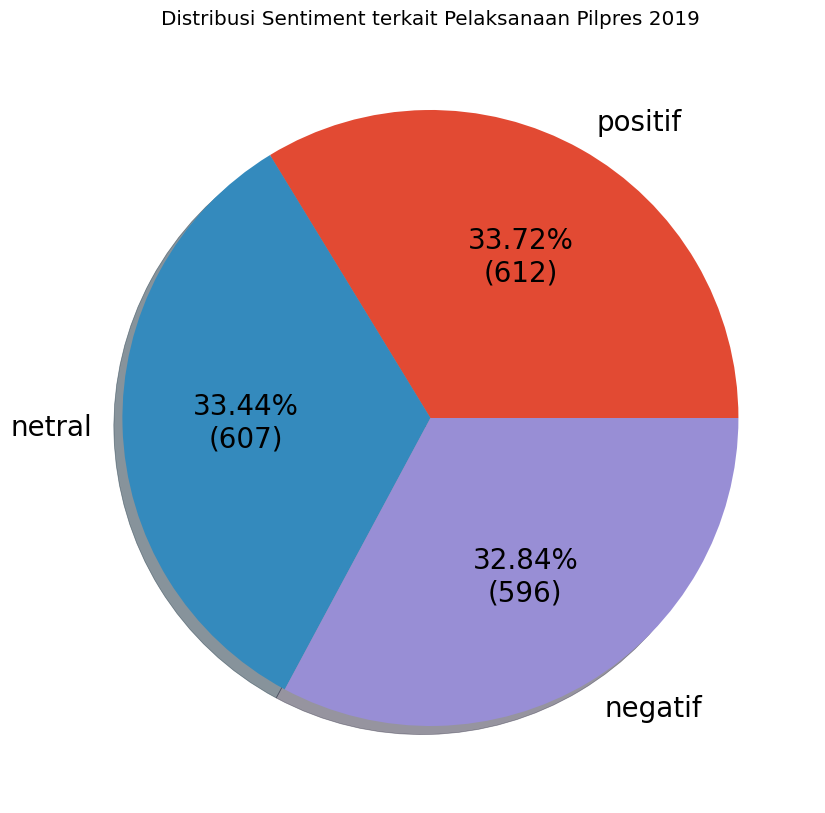

In [81]:
# Overview label distribution
def my_fmt(x):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

total = len(data)
v_counts = data['sentimen'].value_counts()

fig, ax = plt.subplots(figsize = (15, 10))
wdges, labels, autopct = ax.pie(v_counts, labels=v_counts.index, autopct=my_fmt, shadow=True)
plt.setp(labels, fontsize = 20)
plt.setp(autopct, fontsize = 20)
ax.set_title("Distribusi Sentiment terkait Pelaksanaan Pilpres 2019");

## Cleaning Data

In [82]:
# define stopwords from bahasa, sastrawi only has 126 kind of stopwords
stopwords_bahasa = StopWordRemoverFactory()
stopwords_bahasa = stopwords_bahasa.get_stop_words()

# enrich stopwords with current dataset
stopwords_bahasa = stopwords_bahasa + [
    "yg", "utk", "https", "bit", "org", "jg",
    "com", "dan", "yang", "akan"
]
stopwords_bahasa = set(stopwords_bahasa)

## Word Distribution Analysis

In [83]:
# define color_map function to generate similar color pallete on wordcloud
def color_map(word, *args, **kwargs):
    return choice(['#EB4747', '#ABC9FF', '#D7BBF5'])

In [84]:
def generate_wordcloud(list_comment_words, title):
    comment_words = " ".join(list_comment_words)
    wordcloud = WordCloud(
        width = 800, height = 500,
        background_color ='white',
        stopwords = stopwords_bahasa,
        min_font_size = 20,
        color_func = color_map
    ).generate(comment_words)

    plt.figure(figsize = (20, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontsize = 25, pad = 20)
    plt.tight_layout(pad = 0);

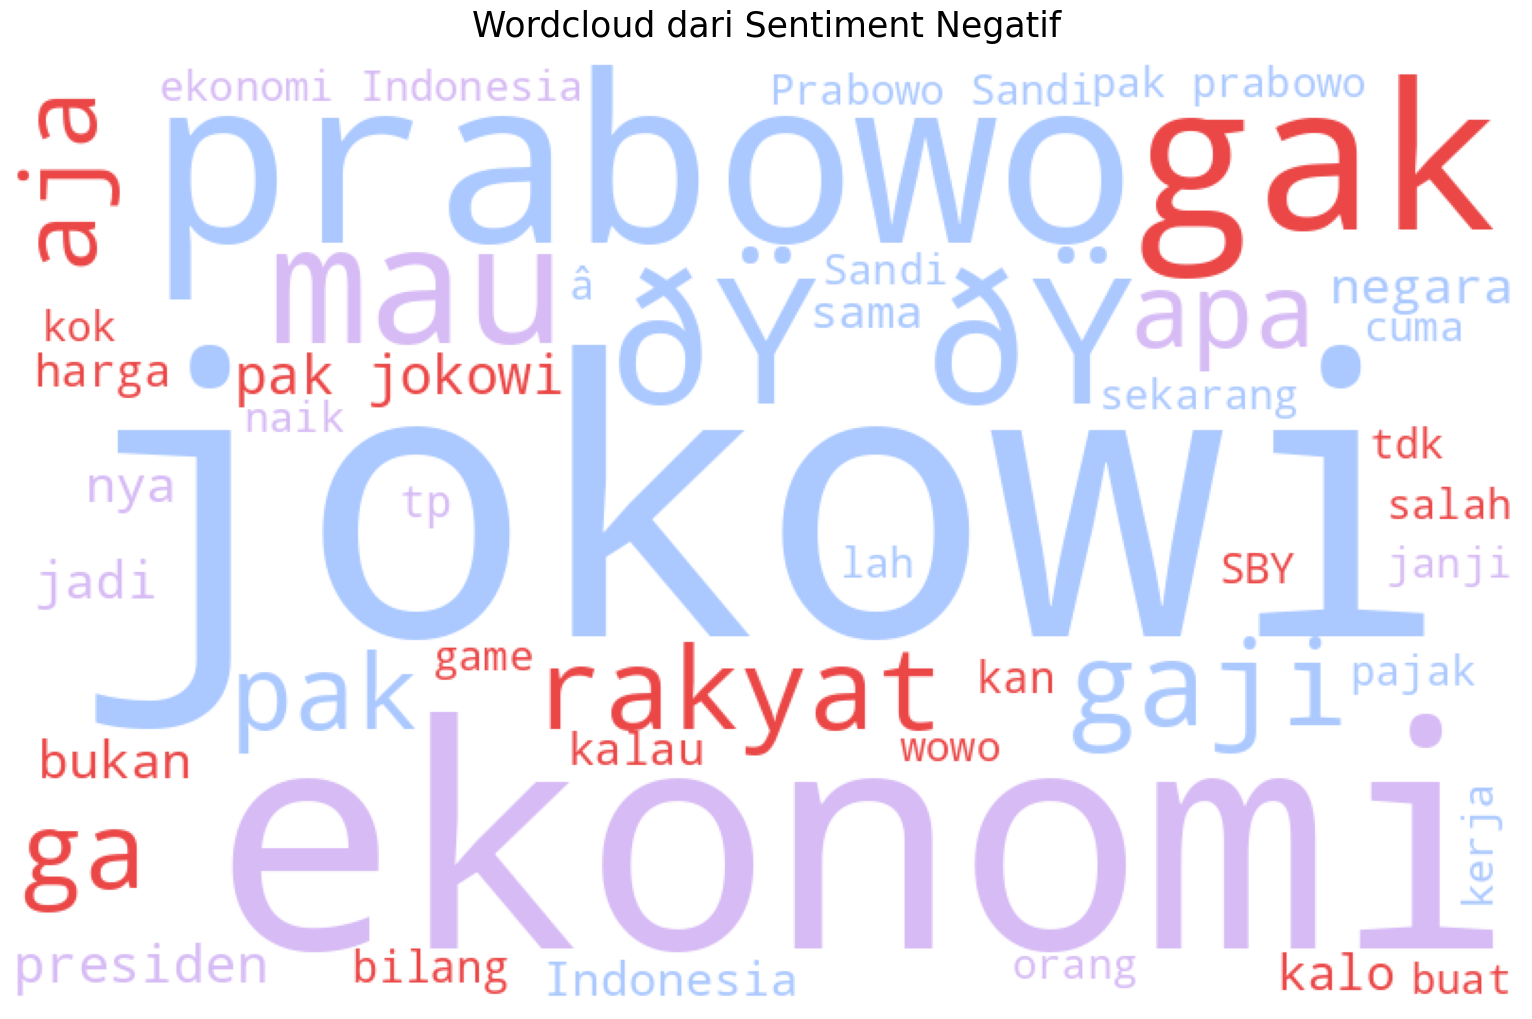

In [85]:
filter_df = data[data["sentimen"] == "negatif"]["tweet"]
generate_wordcloud(filter_df.tolist(), "Wordcloud dari Sentiment Negatif")

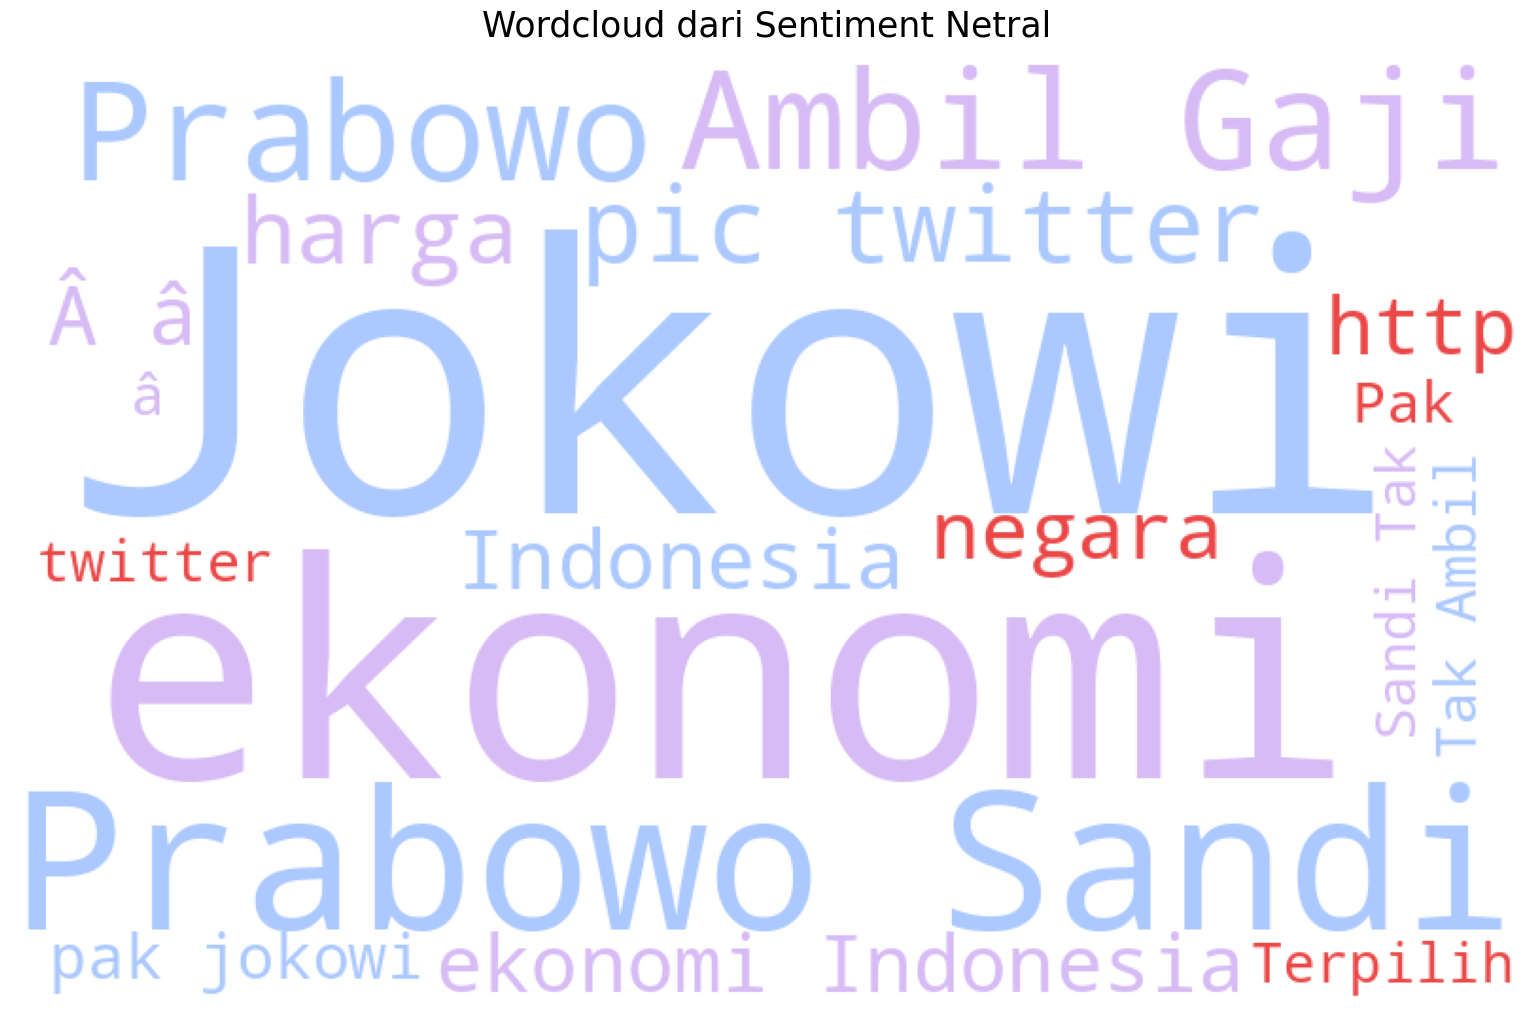

In [86]:
filter_df = data[data["sentimen"] == "netral"]["tweet"]
generate_wordcloud(filter_df.tolist(), "Wordcloud dari Sentiment Netral")

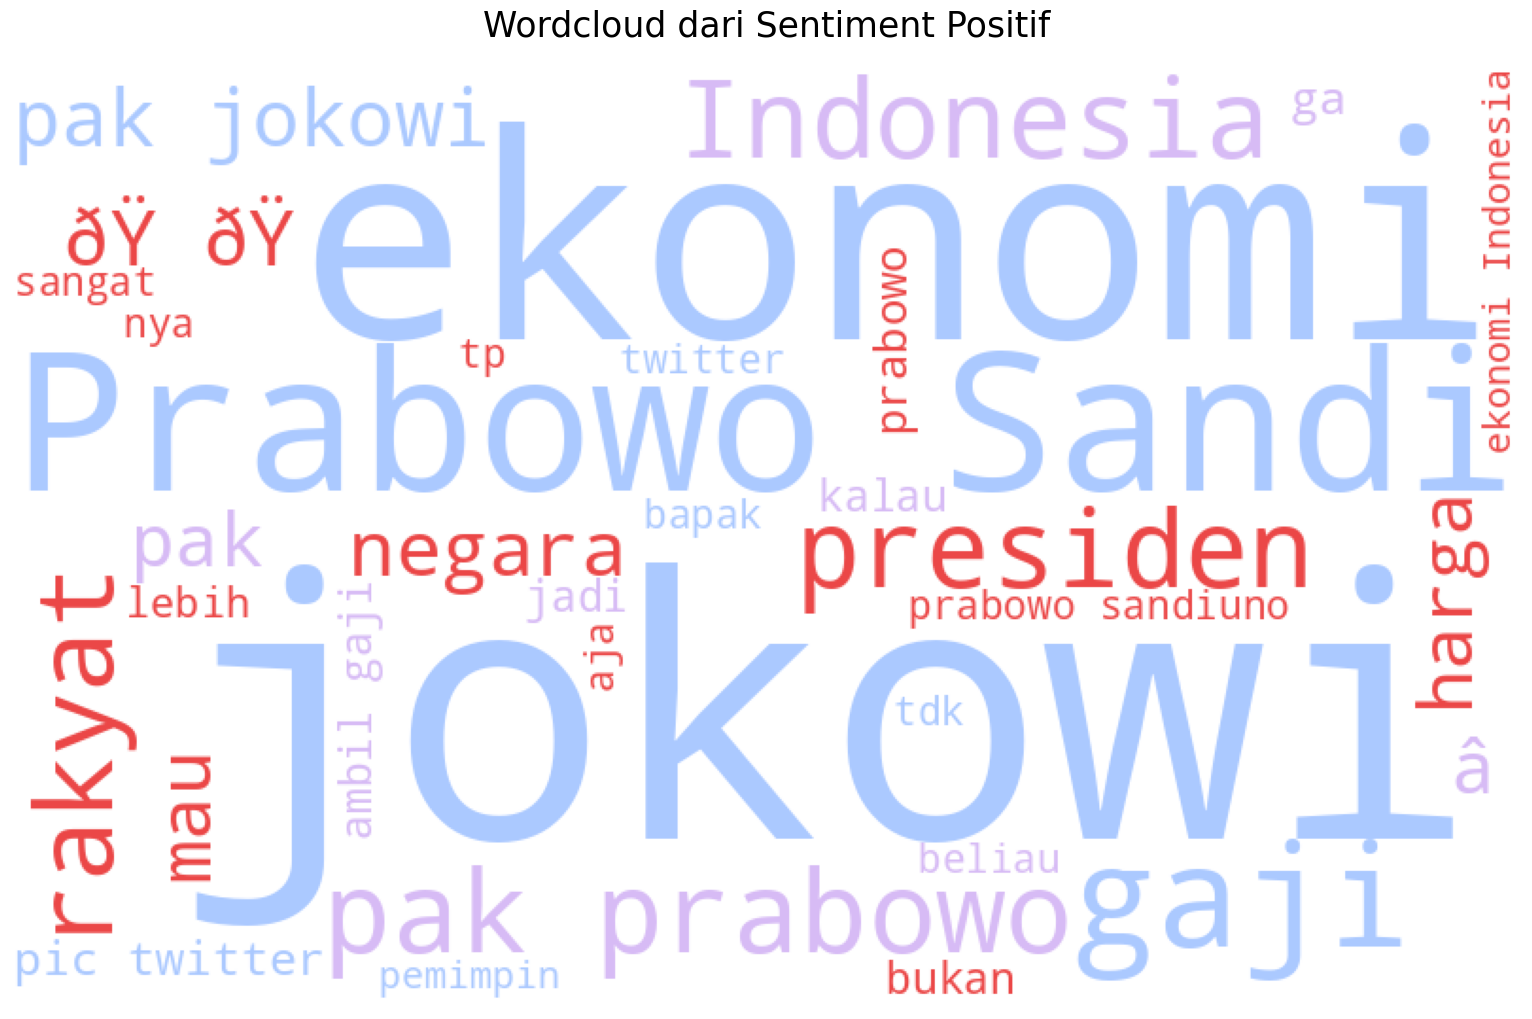

In [87]:
filter_df = data[data["sentimen"] == "positif"]["tweet"]
generate_wordcloud(filter_df.tolist(), "Wordcloud dari Sentiment Positif")

## Topic Distribution Analysis

![](https://miro.medium.com/v2/resize:fit:1400/0*DxAqCqx6dzg0KQlg.png)

### Text Cleaning

In [88]:
# Load libraries
import re
import string
from tqdm import tqdm
from bertopic import BERTopic
import plotly.graph_objects as go

In [89]:
# Set progress bar
tqdm.pandas()

In [99]:
# remove link
def remove_link(text):
    return re.sub(r'http\S+', '', text)

# remove non-ascii characted
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+',' ', text)

# remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

# remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z@]\b", "", text)

# NLTK word rokenize
def word_tokenize_wrapper(text):
    return text.split()

# stopwords removal
def word_removal(text):
    return " ".join([word for word in text.split() if word not in stopwords_bahasa])

In [100]:
# Preprocess twitter data
data['clean_tweet'] = data['tweet'].progress_apply(
    lambda x: remove_singl_char(remove_whitespace_multiple(
        remove_punctuation(remove_number(remove_non_ascii(remove_link(x))))
)))

100%|██████████| 1815/1815 [00:00<00:00, 25033.75it/s]


In [101]:
# Overview tweet vs clean_tweet comparison
data[['tweet', 'clean_tweet']].head()

,tweet,clean_tweet
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,Kata prabowo Indonesia tidak dihargai bangsa a...
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",Batuan Langka Tasbih Jokowi Hadiah dari Habib ...
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",Di era Jokowi ekonomi Indonesia semakin baik I...
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",Bagi Sumatera Selatan Asian Games berdampak pd...
4,Negara kita ngutang buat bngun infrastruktur y...,Negara kita ngutang buat bngun infrastruktur y...


In [102]:
# Define content / document used for topic modeling based on HBDScan
content = data['clean_tweet'].tolist()

In [103]:
# Fitting model
topic_model = BERTopic(
    min_topic_size = 25, n_gram_range = (2, 3),
    verbose = True)
topics, _ = topic_model.fit_transform(content)

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

2023-07-13 04:14:59,945 - BERTopic - Transformed documents to Embeddings
2023-07-13 04:15:10,316 - BERTopic - Reduced dimensionality
2023-07-13 04:15:10,474 - BERTopic - Clustered reduced embeddings


In [104]:
# Overview topic information
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,249,-1_raja salman_jokowi dan_jokowi dan raja_dan ...,"[raja salman, jokowi dan, jokowi dan raja, dan...",[Capres bilang didebat keadaan ekonomi Indones...
1,0,1099,0_prabowo sandi_ambil gaji_pak jokowi_pak prabowo,"[prabowo sandi, ambil gaji, pak jokowi, pak pr...",[PrabowoSandi Tak Akan Ambil Gaji Sepeser pun ...
2,1,268,1_sebelum jokowi_presiden sebelum_jadi preside...,"[sebelum jokowi, presiden sebelum, jadi presid...",[kesalahan arah ekonomi yang mengakibatkan ter...
3,2,72,2_main game_asian games_mobile legend_jokowi h...,"[main game, asian games, mobile legend, jokowi...",[Dampak ekonomi tdk langsung Asian Games melip...
4,3,49,3_industri kreatif_pentingnya sisi industri_gl...,"[industri kreatif, pentingnya sisi industri, g...",[PilihOrangBaik PilihJelasIslamnya PilihBajuPu...
5,4,47,4_ekonomi digital_pak jokowi_digital dan_ekono...,"[ekonomi digital, pak jokowi, digital dan, eko...",[Yang jadi pokok penting dari pertanyaan pak j...
6,5,31,5_mobile legend_esport mobile_main mobile lege...,"[mobile legend, esport mobile, main mobile leg...",[Udah manusia kuper macam lu ga ngerti mobile ...


In [105]:
def vis_topics(topic_cluster: int) -> None:

    data = topic_model.get_topic(topic_cluster)

    # Separate the labels and values into separate lists
    labels = [item[0] for item in data]
    values = [item[1] for item in data]

    # Create the bar plot
    fig = go.Figure(data=go.Bar(y=labels, x=values, orientation='h'))

    # Set the layout
    fig.update_layout(
        title=f"Top Keywords on Clusters {topic_cluster}",
        xaxis_title="Frequency",
        yaxis_title="Keywords",
        yaxis=dict(autorange="reversed")
    )

    # Display the plot
    fig.show()

In [106]:
vis_topics(-1)

In [72]:
vis_topics(0)

In [73]:
vis_topics(1)

In [74]:
vis_topics(2)

In [98]:
vis_topics(3)

In [107]:
vis_topics(4)

In [108]:
vis_topics(5)

In [109]:
# Visualize topic distribution
topic_model.visualize_topics()

## Specific Topic Distribution Analysis

In [203]:
# Load libraries
import gensim
from gensim import corpora
from operator import itemgetter
from gensim.similarities import MatrixSimilarity

In [204]:
# Define function to generate LSI index based on query terms
class generate_model_terms_corpus(object):
    """
    Issue

      Gensim approach in single word approach isnt suitable due document comparison
    is between single / phrase words with total document, cause an anomaly relevant score.

    Suggest

      Convert similarites embedding using string similarities and create proper cluster to
    reduce out-of-context semantic suggestion.
    """
    def __init__(self, data: pd.DataFrame) -> None:

        self.data = data.reset_index(drop = True)

        self.data['tweet_tokenize'] = self.data['clean_tweet'].apply(word_tokenize_wrapper)
        content = self.data['tweet_tokenize']
        self.dictionary = corpora.Dictionary(content)
        corpus = [dictionary.doc2bow(desc) for desc in content]

        self.tweet_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
        self.tweet_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

        gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', tweet_tfidf_model[corpus])
        gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',tweet_lsi_model[tweet_tfidf_model[corpus]])
        tweet_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
        tweet_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

        self.tweet_index = MatrixSimilarity(tweet_lsi_corpus, num_features = tweet_lsi_corpus.num_terms)

    def search_similar_context(self, search_term):

        query_bow = self.dictionary.doc2bow(word_tokenize_wrapper(search_term))
        query_tfidf = self.tweet_tfidf_model[query_bow]
        query_lsi = self.tweet_lsi_model[query_tfidf]

        self.tweet_index.num_best = 5
        tweets_list = self.tweet_index[query_lsi]
        tweets_list.sort(key=itemgetter(1), reverse=True)
        tweets_names = []

        for i, idx in enumerate(tweets_list):
            tweets_names.append({
                "Content" : self.data['tweet'][idx[0]],
                "Relevant Score" : round((idx[1] * 100), 2)
            })
            if i == (tweet_index.num_best - 1):
                break

        return pd.DataFrame(tweets_names, columns=['Content', 'Relevant Score'])

class generate_model_terms_spokesperson(object):
    """
    Solution

        Due contextual embedding is failed to find issue on tweets comment, we convert
    approach into simple string filtering and might have proper result syncronized query input and data_filter result.

    Issue

        Due rule-based approach, result might be not relevant or might be approach as non-context result based on query.
    """
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data

    def search_similar_context(self, query: str) -> pd.DataFrame:
        data_filter = self.data[self.data['clean_tweet'].str.contains(query)].sample(5, replace=True)
        return data_filter[['clean_tweet']]

### Negatif Topic Related spesific Query

In [205]:
# Create semantic searching based on negatif sentiment
filter_df = data[data['sentimen'] == "negatif"]
semantic_negatif = generate_model_terms_spokesperson(filter_df)

In [206]:
semantic_negatif.search_similar_context("jokowi")

,clean_tweet
1023,Ketika seorang presiden menganggap mainan boca...
1008,How to repair that shit dudemisal kata prabowo...
1281,trik menurunkan harga pangan mengambil hati r...
1383,PrabowoSalahkanSBY Pak jokowi menjelaskan apa ...
857,Om Wowo menyebut kesalahan arah ekonomi Indone...


In [207]:
semantic_negatif.search_similar_context("prabowo")

,clean_tweet
101,kalau emang prabowo mau seenggaknya prepare un...
27,Model ngeles petruk Sudah ketaker Berbusa dide...
1292,Beda sama jokowi dia gk menghargai sby itulah ...
27,Model ngeles petruk Sudah ketaker Berbusa dide...
429,Ohh prabowo ikuti karyawannya Yg tidak mengamb...


In [208]:
semantic_negatif.search_similar_context("sandiaga uno")

,clean_tweet
1711,Nonton debat saya melihat inkonsistensi pandan...
619,Waktu tax amnesty kemarin prabowo sama sandiag...
1711,Nonton debat saya melihat inkonsistensi pandan...
1711,Nonton debat saya melihat inkonsistensi pandan...
1711,Nonton debat saya melihat inkonsistensi pandan...


### Positif Topic Related spesific Query

In [209]:
# Create semantic searching based on negatif sentiment
filter_df = data[data['sentimen'] == "positif"]
semantic_positif = generate_model_terms_spokesperson(filter_df)

In [210]:
semantic_positif.search_similar_context("jokowi")

,clean_tweet
1249,Asiknya jokowi sudah bekerja dan kerjanya bisa...
268,Nasionalisme beliau luar biasa didunia interna...
54,Dalam penjelasannya Kyai KHMarufAmin mau menja...
1200,Hmmm vPrabowoSalahkanSBY PS bilang didebat kea...
1294,Yg dikatakan Pak prabowo itu benar Kita semua ...


In [211]:
semantic_positif.search_similar_context("prabowo")

,clean_tweet
426,Semoga president yang terpilih nanti bisa menu...
1731,PENGABDIAN KE NEGARA prabowosandiuno DENGAN KE...
84,Mungkin pak prabowo mengharap ketulusan karyaw...
928,Mertua saya guru honorer mengabdi dr SMP ke SM...
1322,Bener setelah kampanye rakyat membantu sukarel...


In [212]:
semantic_positif.search_similar_context("sandiaga uno")

,clean_tweet
916,Masuk akal bagi prabowo sandi karena sandiaga ...
579,Presiden Prabowo dan wakil presiden sandiaga u...
916,Masuk akal bagi prabowo sandi karena sandiaga ...
809,Jujur akupun ngga tau bedanya ekonomi makro da...
809,Jujur akupun ngga tau bedanya ekonomi makro da...
